# `Laboratorio 6 | Machine Learning`
* Marco Ferraro | B82957
* Roy Padilla | B85854

Descarga del dataset

In [55]:
import torchvision

# Descarga del set de datos
train = torchvision.datasets.MNIST(".", download=True)

# Extracción de datos
x = train.data.float()
y = train.targets

Clase para manejar el dataset

In [56]:
import torch

class Dset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

Pruebas de mostrado de imágenes

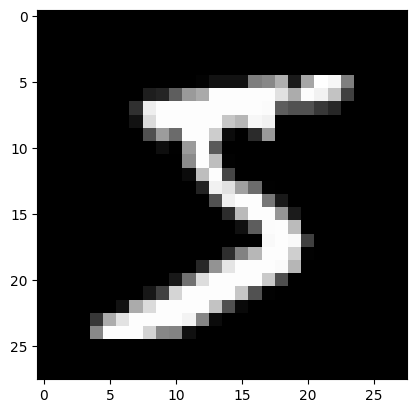

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from torch import flatten

def plot_image(img,save=False,name=None):
    cmap = 'gray' if img.shape[0]==1 else None
    data = (img.detach()*(255 if img.max()<=1 else 1)).permute((1,2,0)).numpy().astype(np.uint8)
    plt.figure()
    plt.imshow(data,cmap=cmap)
    plt.show()
    if save:
        if img.shape[0]==1:
            plt.imsave(name, data.squeeze(), cmap=cmap)
        else:
            plt.imsave(name, data, cmap=cmap)

img_number = 0
img = x[img_number]
plot_image( img[None, :], True, '{}.png'.format(img_number))

Filtrado de las imágenes


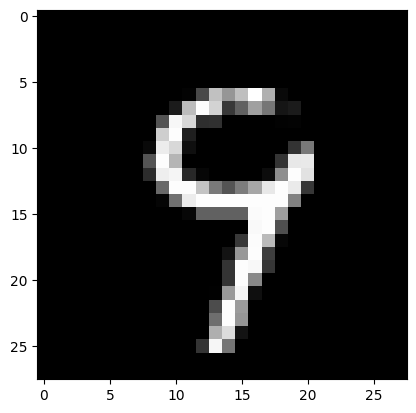

In [58]:
from torch import nonzero

target_number = 9

indeces = y == target_number

x_true = x[nonzero(indeces)]

img_number = 1378
img = x_true[img_number]
plot_image( img, True, '{}.png'.format(img_number))


`Clase Classifier`: 
Se va a encarga de determinar si una imagen es o no perteneciente a un dígito en específico o no

In [59]:
from torch import nn, flatten, tensor, cat, device, ones, zeros
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

DEVICE = device("cuda:0")

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Primera convolución
        # Entra una imagen 1x28x28
        self.conv1 =  nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = (3,3), stride = 1, padding = 'same')
        # Sale una imagen de 4x28x28
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        # img de 4x14x14 => 784

        # Red neuronal
        self.fc1 = nn.Linear(784, 600)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(600, 1) # Salida de si es el dígito o no => 1 = Verdadera | 0 = Falso
        self.act2 = nn.Sigmoid()

        # Dropout (opcional)
        self.dropout = nn.Dropout(p = 0.2)
    
    def forward(self, x):
        ''' 
            Sobre-escritura del método de forward propagation, aplicando las capas convolucionales
            y luego las capas densas de la red neuronal
        '''
        # Aplicación de las convoluciones
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = flatten(x, 1)

        # Capas densas
        x = self.act1(self.fc1(x))
        out = self.act2(self.fc2(x))

        return out

    
def train_classifier(opt, model, x_true, x_false, accuracy=None, max_iters=100, batch_size=1000):
    '''
        Método de entrenamiento del clasificador donde se toma el conjunto x de imágenes verdades
        y el conjunto de imágenes falsas generadas por el generador para que determine si es o no
        el dígito objetivo.
    '''
    iter_counter = 0
    model_accuracy = 0
    finish_by_accueracy = False
    loss_func = nn.BCELoss() # Binary Cross Entropy

    losses = []
    while (iter_counter < max_iters and not(finish_by_accueracy)):
        # Generación aleatoria de los índices para utilizar en el entrenamiento
        true_batch = np.random.randint(0, x_true.shape[0], batch_size)
        false_batch = np.random.randint(0, x_false.shape[0], batch_size)

        # Obtención del conjunto de entrenamiento
        # conjunto para predecir 1
        # conjunto para predecir 0
        
        X_train = tensor(data= cat((x_true[true_batch], x_false[false_batch])), dtype= torch.float, device=DEVICE)
        y_train = tensor(data= cat((ones(batch_size) , zeros(batch_size))) , dtype= torch.float, device=DEVICE)
        model = model.to(DEVICE)

        train_dset = Dset(X_train, y_train)
        train_loader = DataLoader(dataset= train_dset, batch_size = batch_size, shuffle=False)
        torch.cuda.empty_cache()
        # Entrenamiento
        for i, (inputs, labels) in enumerate(train_loader):
            model.train()
            opt.zero_grad()
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            y_pred = model( inputs )
            loss = loss_func(y_pred, labels[:, None])
            loss.backward()
            opt.step()
            losses.append(loss.item())
        
        # Falta calcular el accuracy
        finish_by_accueracy = True if accuracy == None else accuracy > model_accuracy
        iter_counter += 1
        
            

In [60]:
import torch.nn.functional as F


class Generator(nn.Module):
  def __init__(self, input_dim, output_dim=784):
    super(Generator, self).__init__()
    
    # 5 Fully connected layers
    self.fc1 = nn.Linear(input_dim, 256)
    self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features * 2)
    self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features * 2)
    self.fc4 = nn.Linear(self.fc3.out_features, self.fc3.out_features * 2)
    self.fc5 = nn.Linear(self.fc4.out_features, output_dim)

  def forward(self, x):
    x = torch.sigmoid(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))
    x = torch.sigmoid(self.fc5(x))

    return torch.nn.LogSoftmax(x)




Generator Training

In [61]:
from torch.autograd import Variable
import torch.optim as optim

batch_size = 1
input_dim = 150
lr = 2e-4

gen = Generator(input_dim=input_dim).to(DEVICE)
gen_optimizer = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss() 

for e in range(100):
  gen.zero_grad()

  x = Variable(torch.randn(batch_size, input_dim).to(DEVICE))
  y = Variable(torch.ones(batch_size, 1).to(DEVICE))

  g_output = gen(x)
  # discrimitor output
  # gen loss = criterion(discrimator, y)

  # gen loss.backward

  gen_optimizer.step()
  print(g_output)


AttributeError: 'LogSoftmax' object has no attribute 'shape'

In [ ]:
from torch import optim
from torch import tensor

classifier = Classifier()

opt = optim.Adadelta(classifier.parameters(), lr= 0.005)

train_classifier(opt=opt, model = classifier, x_true = x_true, x_false = x_true, accuracy = 1, max_iters= 1)